### In this tutorial script, we're going to take a look at empirical haemodynamic response function estimation using real data in MATLAB.  The dataset can be found [here](https://openfmri.org/dataset/ds000105/) if you'd like to follow along.

In [1]:
%% Getting Organized
% Define our folder locations
root_dir = pwd;
data_dir = [root_dir,'/ds000105_R2.0.2'];
sub_dir = folder('ds000105_R2.0.2/sub*');

% variables
TR = 2.5;
dims = [40,64,64];

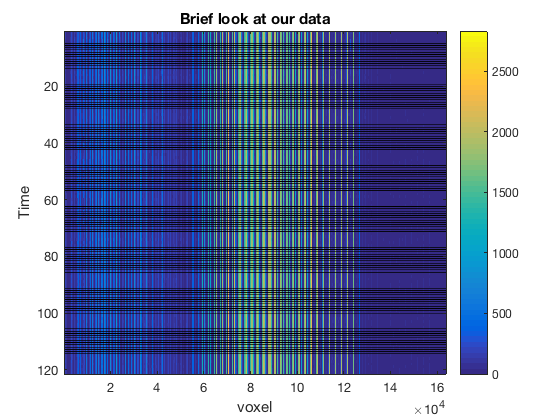

In [2]:
%% Load up single functional run and task info
cd([sub_dir{1},'/func']);
functional_imgs = file('sub*.nii.gz');
% must uncompress for matlab to take it
%gunzip(functional_imgs)
functional_imgs = file('sub*.nii');
task_info = file('sub*.tsv');
%% Load up image
hdr = spm_vol(functional_imgs{1});
img = spm_read_vols(hdr);
% convert to time x voxel
imgDat = permute(img,[4,1,2,3]);
imgDat = imgDat(:,:);
% make some color data for plotting, this will come in handy later.
[X,Y,Z] = meshgrid(1:40,1:64,1:64);
colorDat = [X(:),Y(:),Z(:)];
colorDat = bsxfun(@rdivide,colorDat,max(colorDat));
%% Load up task data
task = tdfread(task_info{1},'tab');
% task has fields onset, duration, trial_type
imagesc(imgDat)
hold on
x = [ones(size(task.onset)), size(imgDat,2)*ones(size(task.onset))];
y = [task.onset/2.5,task.onset/2.5];
for i = 1:length(x)
    plot(x(i,:),y(i,:),'k','linewidth',.5)
end
colorbar
ylabel('Time')
xlabel('voxel')
title('Brief look at our data')

### Ugly, I know - but a good sanity check and overview of what the data looks like.  This plot shows the signals of each individual voxel in the functional time series (we're disregarding 3D position at this point).  What you'll notice is that most voxels have low signal and are likely not from the brain.  In the remaining data, there is significant variability in signal intensity.  I've also plotted the onsets in black.  You can't see the task evoked haemodynamic response functions at this point but we'll get there soon.  Next, lets look at an individual voxel's time series.

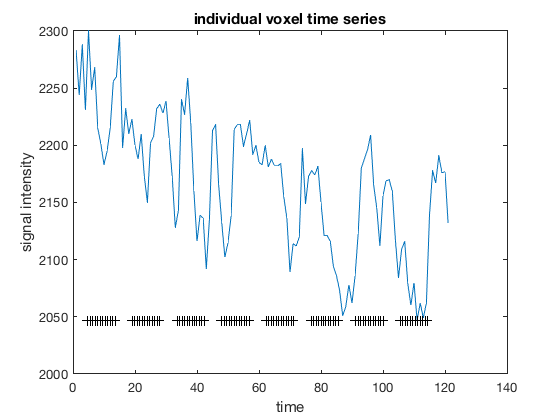

In [3]:
%% Next lets look at an individual voxel's time series.
dataMean = mean(imgDat);
[~,loc] = find(dataMean>prctile(dataMean,99),1,'first');
%plot signal
plot(imgDat(:,loc))
hold on
%plot onsets
plot(task.onset/2.5,min(imgDat(:,loc))*ones(size(task.onset)),'k+')
xlabel('time')
ylabel('signal intensity')
title('individual voxel time series')

### Noisy? yes.  Task related? maybe.  Lets detrend and normalize the data to prepare to look at HRFs

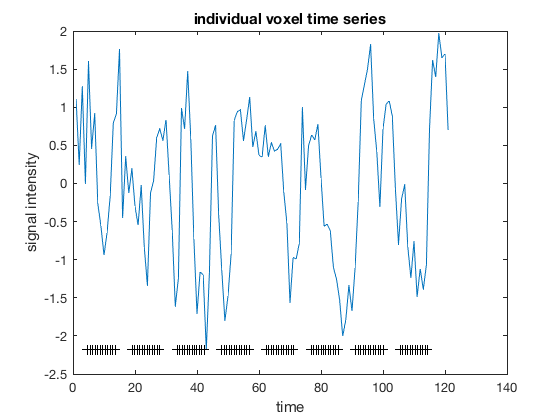

In [4]:
% detrend (just quick and dirty, do high-pass filter )
imgDat = detrend(imgDat,'linear');
imgDat = zscore(imgDat);
plot(imgDat(:,loc))
hold on
%plot onsets
plot(task.onset/2.5,min(imgDat(:,loc))*ones(size(task.onset)),'k+')
xlabel('time')
ylabel('signal intensity')
title('individual voxel time series post detrend and normalization')

### Ok now we're ready to get started with the meat of the analysis: Finite impulse response estimation.  

### What we're doing here is creating a linear model to estimate the time course of the signal evoked by presenting the subjects with images.  We do this for each voxel.  

### In terms of models, we're creating a model that estimates intercepts at the first time point after stimulus onset, then the second, and so on.  The model order is the number of post event time steps we want to model. 

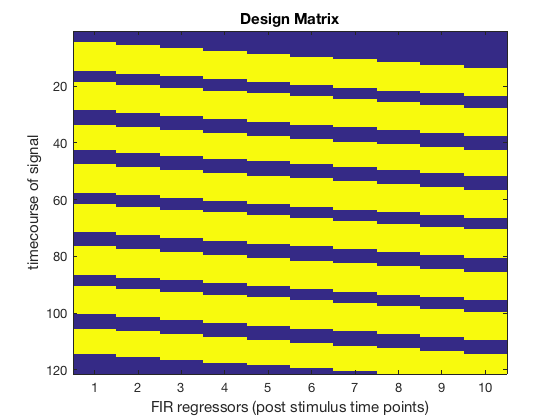

In [5]:
%% Do finite impulse response to get empirical HRF for each voxel
% create FIR design matrix
firOrder = 10;% order is in TR time and should be about 33seconds/TR
X = zeros(size(imgDat,1),firOrder);
for reg = 1:firOrder
    X(round(task.onset/2.5)+(reg-1),reg)=1;
end
%limit X to what we have data for
X = X(1:size(imgDat,1),:);
imagesc(X)
xlabel('FIR regressors (post stimulus time points)')
ylabel('timecourse of signal')
title('Design Matrix')

In [6]:
%% now lets do model estimation
Betas = pinv(X)*imgDat;% not the most stable version of the normal equation but ok for our purposes
%stats
Yhat = X*Betas;
Res = imgDat - Yhat;

SStotal = nansum(bsxfun(@minus,imgDat,nanmean(imgDat)).^2);
SSeffect = nansum(bsxfun(@minus,Yhat,nanmean(Yhat)).^2);
SSerror  = nansum(Res.^2);
df = rank(X)-1;
dferror = size(imgDat,1) - df - 1;
R2 = SSeffect ./ SStotal;
F = (SSeffect ./ df) ./ (SSerror ./ dferror);
p = 1 - fcdf(F,df,dferror);
%[Betas,dev,stats] = glmfit(X,imgDat)

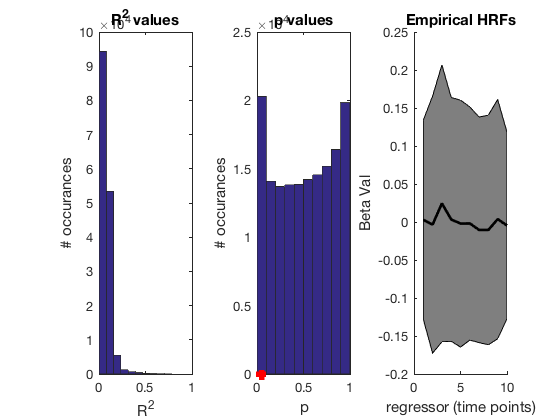

In [7]:
%% Lets take a brief overview at the results.
figure
subplot(1,3,1)
hist(R2)
title('R^2 values')
xlabel('R^2')
ylabel('# occurances')

subplot(1,3,2)
hist(p)
hold on
plot(.05,0,'r+','linewidth',5)
title('p values')
xlabel('p')
ylabel('# occurances')

subplot(1,3,3)
errorpatch([1:firOrder],Betas','k');
xlabel('regressor (time points)')
ylabel('Beta Val')
title('Empirical HRFs')

### Do you see it?  The average of our estimated HRFs kinda looks like a traditional HRF (right plot, black line), but there's lots and lots of noise since most of our signal isn't even in the brain.  Now lets start getting rid of all the junk data.  To do this, we're going to do a conservative threshold at p=.01.  This means that we're going to key in on the voxels that demonstrated some form of stereotyped evoked response to the task.

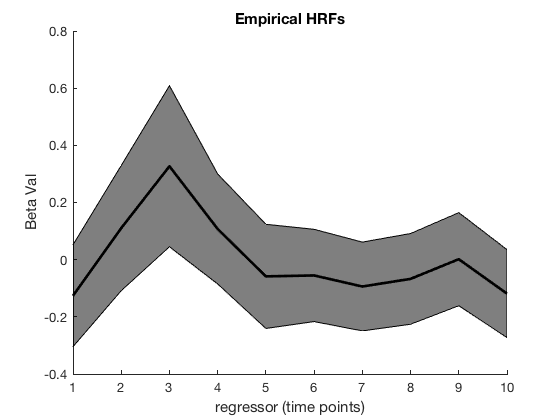

In [8]:
%% Threshold at p=.1
keeperBetas = Betas(:,p<=.01);
errorpatch([1:firOrder],keeperBetas','k');
xlabel('regressor (time points)')
ylabel('Beta Val')
title('Empirical HRFs')

### Much better.  This now actually looks like an HRF.  

### Next, we're going to do some visualization of our results to look if we have different types of response profiles in the data.  To do this, I'm using t-sne (t-distributed stochastic neighbor embedding), which reduces the dimensionality of our data and does a much better job preserving topology than other forms of dimensionality reduction.  This is going to take awhile and requires that you have the barnes-hut optimized version of t-sne installed.  You can do this [here](https://lvdmaaten.github.io/tsne/).  This takes around 5 minues on my machine, you may want to grab some coffee at this point if you're following along.

In [9]:
cd(root_dir)
if ~exist('mappedX.mat','file')
    mappedX = fast_tsne(keeperBetas', 2, 10, 30);
    save('mappedX.mat','mappedX')
else
    load('mappedX.mat')
end

Elapsed time is 62.331292 seconds.


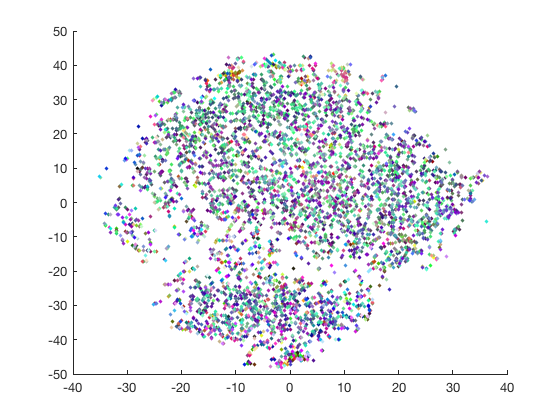

In [10]:
cdat = colorDat(p<=.01,:);
scatter(mappedX(:,1),mappedX(:,2),10,cdat,'filled')

### The colors here aren't particularly informative.  I've simply made it so more red means we're more lateral in the brain,  more green means more anterior, and more blue means we're more dorsal.

### Next lets actually look at the estimated HRF functions in this space.

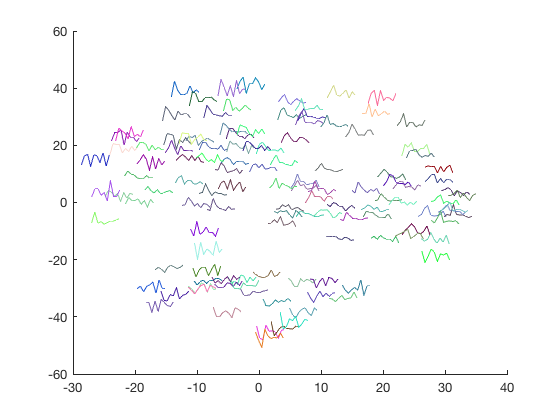

In [11]:
figure 
hold on
for i = randperm(size(mappedX,1),round(size(mappedX,1)/50))
    plot(mappedX(i,1)+.5*[1:10],mappedX(i,2)+3*keeperBetas(:,i)','color',cdat(i,:))
end
drawnow

### Interesting. You can see that very few voxels actually produce a single humped HRF that looks much like the canonical HRF.

### Only being a single run from a single subject though, this is bound to be noisy data.  Next lets run all runs of this subject.  

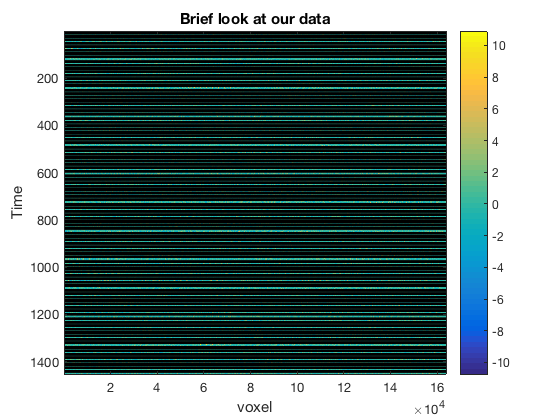

In [12]:
%% Now do a full Subject
cd([sub_dir{1},'/func']);
functional_imgs = file('sub*.nii.gz');
% must uncompress for matlab to take it
%gunzip(functional_imgs)
functional_imgs = file('sub*.nii');
task_info = file('sub*.tsv');
% make some color data for plotting, this will come in handy later.
[X,Y,Z] = meshgrid(1:40,1:64,1:64);
cdata = [X(:),Y(:),Z(:)];
cdata = bsxfun(@rdivide,cdata,max(cdata));
    
%% Load up image
imgDat = [];
onsets = [];
colorDat = [];
time = 0;
for i = 1:numel(functional_imgs)
    hdr = spm_vol(functional_imgs{i});
    img = spm_read_vols(hdr);
    % convert to time x voxel
    img = permute(img,[4,1,2,3]);
    img = img(:,:);
    img = detrend(img,'linear');
    img = zscore(img);
    imgDat = [imgDat;img];
    %% Load up task data
    task = tdfread(task_info{i},'tab');
    onsets = [onsets;task.onset/2.5+time];
    time=time+size(img,1);
    % color data
    colorDat = [colorDat;cdata];
end
% task has fields onset, duration, trial_type
imagesc(imgDat)
hold on
x = [ones(size(onsets)), size(imgDat,2)*ones(size(onsets))];
y = [onsets,onsets];
for i = 1:length(x)
    plot(x(i,:),y(i,:),'k','linewidth',.5)
end
colorbar
ylabel('Time')
xlabel('voxel')
title('Brief look at our data')

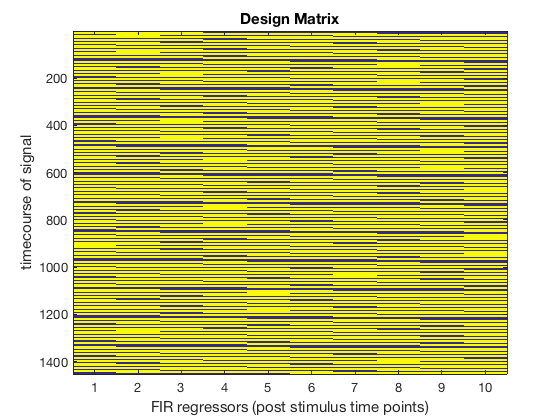

In [13]:
%% Do finite impulse response to get empirical HRF for each voxel
% create FIR design matrix
firOrder = 10;% order is in TR time and should be about 33seconds/TR
X = zeros(size(imgDat,1),firOrder);
for reg = 1:firOrder
    X(round(onsets)+(reg-1),reg)=1;
end
%limit X to what we have data for
X = X(1:size(imgDat,1),:);
imagesc(X)
xlabel('FIR regressors (post stimulus time points)')
ylabel('timecourse of signal')
title('Design Matrix')

In [14]:
%% now lets do model estimation
Betas = pinv(X)*imgDat;% not the most stable version of the normal equation but ok for our purposes
%stats
Yhat = X*Betas;
Res = imgDat - Yhat;

SStotal = nansum(bsxfun(@minus,imgDat,nanmean(imgDat)).^2);
SSeffect = nansum(bsxfun(@minus,Yhat,nanmean(Yhat)).^2);
SSerror  = nansum(Res.^2);
df = rank(X)-1;
dferror = size(imgDat,1) - df - 1;
R2 = SSeffect ./ SStotal;
F = (SSeffect ./ df) ./ (SSerror ./ dferror);
p = 1 - fcdf(F,df,dferror);

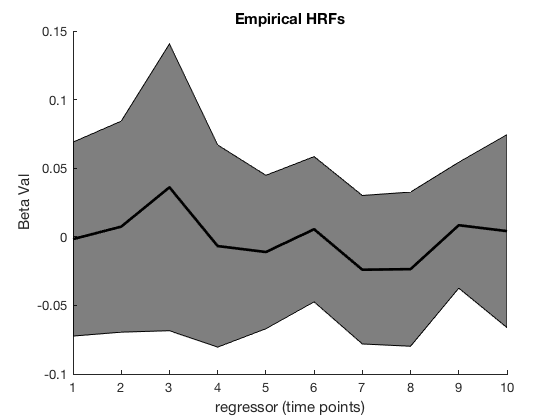

In [15]:
keeperBetas = Betas(:,p<=.01);
errorpatch([1:firOrder],keeperBetas','k');
xlabel('regressor (time points)')
ylabel('Beta Val')
title('Empirical HRFs')

In [16]:
cd(root_dir)
if ~exist('mappedX1.mat','file')
    mappedX = fast_tsne(keeperBetas', 2, 10, 30);
    save('mappedX1.mat','mappedX')
else
    load('mappedX1.mat')
end

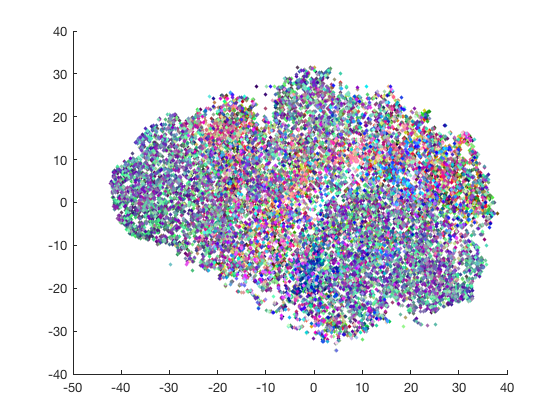

In [17]:
cdat = colorDat(p<=.01,:);
scatter(mappedX(:,1),mappedX(:,2),10,cdat,'filled')

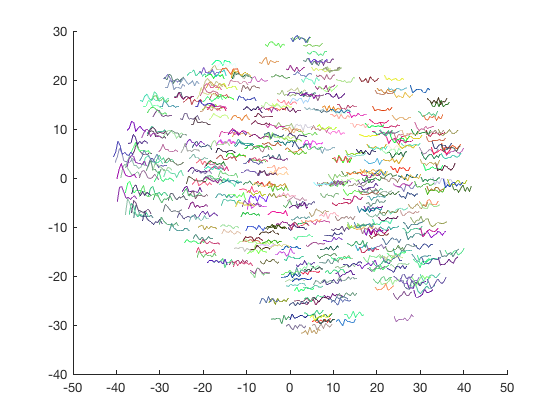

In [18]:
figure 
hold on
for i = randperm(size(mappedX,1),round(size(mappedX,1)/50))
    plot(mappedX(i,1)+.5*[1:10],mappedX(i,2)+3*keeperBetas(:,i)','color',cdat(i,:))
end
drawnow

### Interesting.  Again, very few of our significant voxels actually have an HRF that looks like the canonical HRF.  In my plot it's the left side that has HRFs that look similar to the canonical HRF, but this may change if you rerun.

### So what do we do next?  If we're going to use a single empirical HRF to analyze our data, we'll need one single-humped hrf that isn't so noisy.

### What I show here is very similar to how I solved this problem in the paper:

#### CT Kyle, JD Stokes, JS Lieberman, AS Hassan, AD Ekstrom. (2015). Successful retrieval of competing spatial environments in humans involves hippocampal pattern separation mechanisms. Elife 4, e10499

### To do this, I use independent component analysis to extract an HRF that explains a large portion of the variance in the data.  In the paper, I do this with all subjects included in the analysis rather than just a single subject.

In [19]:
[weights,sphere,compvars,bias,signs,lrates,activations] = runica(keeperBetas,'verbose','off');
W = weights*sphere;
Wi = inv(W);

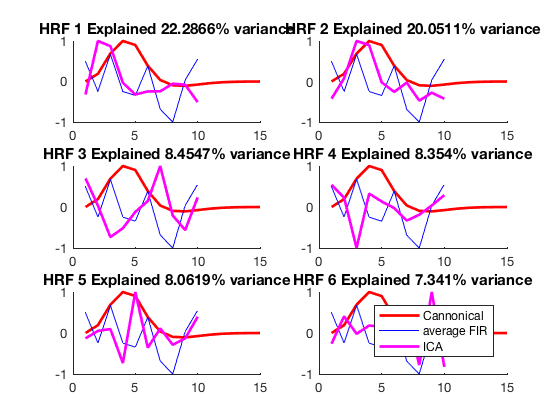

In [20]:
% Plot top 6 components
exVar = [0; [cumsum(compvars)./sum(compvars)]'];
exVar = 100*diff(exVar);
avgHRF = mean(Betas')';
hrf = spm_hrf(2.5);
hrf = conv(hrf,[1;1;1]);
for i = 1:6
    subplot(3,2,i)
    
    hold on
    plot(hrf./max(hrf),'r','linewidth',2)
    plot(avgHRF./max(abs(avgHRF)),'b')
    plot(Wi(:,i)./max(abs(Wi(:,i))),'m','linewidth',2)
    
    title(['HRF ',num2str(i),' Explained ',num2str(exVar(i)),'% variance'])
    if i==6
        legend({'Cannonical','average FIR','ICA'})
    end
end

### The canonical HRF is clearly a poor fit of the data.  With 20% variance explained, we could easily choose to use HRF1, HRF2, or a combination of the two.  Below, I show combining the two top components.

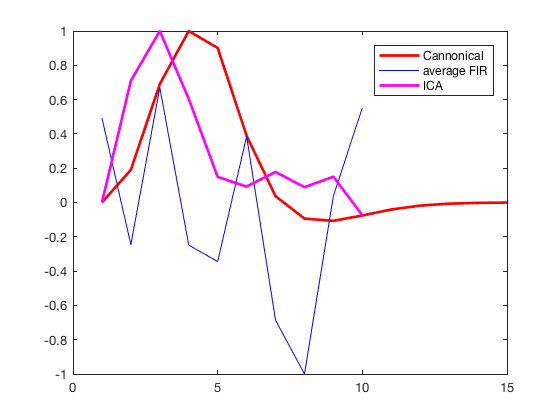

In [21]:
finalHRF = mean(Wi(:,1:2),2);
finalHRF = finalHRF-finalHRF(1);
plot(hrf./max(hrf),'r','linewidth',2)
hold on
plot(avgHRF./max(abs(avgHRF)),'b')
plot(finalHRF./max(finalHRF),'m','linewidth',2)
legend({'Cannonical','average FIR','ICA'})


### Ok all done, once the HRF is calculated you can simply include it in your model in SPM, or use it to calculate your own parameter estimates in your favorite statistical software.  I don't recommend using the pinv method used here since it is not a very stable method of solving the normal equations.